In [4]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm
from typing import Tuple, List
from scipy.stats import ks_2samp, mannwhitneyu
import string
from matplotlib.colors import LinearSegmentedColormap


In [5]:
def is_coprime(a, b):
    """
    return if a and b are coprimes
    """
    return math.gcd(a, b) == 1

def gcdExtended(a, b):
    if a == 0:
        return b, 0, 1
    GCD, x1, y1 = gcdExtended(b % a, a)
    x = y1 - (b // a) * x1
    y = x1
    return GCD, x, y

In [6]:
def get_cipher_lsa(key: int, char_idx: int, start: int = 30) -> int:
    """get cipher from key and char_index"""
    c = 1
    stop_idx = 0
    run_prod_mod = np.zeros(char_idx + 1, dtype=int)
    for n in range(start , key, 1):
        # if not key % 2 and not n % 2:
        #     continue
        # if not is_coprime(key, n):
        #     continue
        c = c * n % key
        run_prod_mod[stop_idx] = c
        if stop_idx == char_idx:
            _, z, _ = gcdExtended(c, key)
            # cong = z * run_prod_mod % key
            if z < 0:
                z += key
            # return (z, np.sum(cong == 1))
            return z
        stop_idx += 1

def get_cipher_lsa_bw(key: int, char_idx: int, end=30) -> int:
    """get cipher from key and char_index"""
    c = 1
    stop_idx = 0
    run_prod_mod = np.zeros(char_idx + 1, dtype=int)
    for n in range(key - 1 - end, 0, -1):
        # if not key % 2 and not n % 2:
        #     continue
        # if not is_coprime(key, n):
        #     continue
        c = c * n % key
        run_prod_mod[stop_idx] = c
        if stop_idx == char_idx:
            _, z, _ = gcdExtended(c, key)
            # cong = z * run_prod_mod % key
            if z < 0:
                z += key
            return z
        stop_idx += 1


def get_cipher_xor(key: int, char_idx: int) -> int:
      return key ^ char_idx

In [8]:
def get_stat_scores(stat_func, df):
  """compare the cipher distributions if each character using the given stat_func"""
  n_cols = len(df.columns)
  stat_table = np.zeros((2, n_cols, n_cols))
  for i, col1 in enumerate(df.columns):
    for j, col2 in enumerate(df.columns):
      stat_score = stat_func(df[col1].values, df[col2].values)
      stat_table[[0, 1], i, j] = stat_score
  return stat_table

def test_all(chars_range: range, keys_range: range, cipher_func) -> pd.DataFrame:
  """generate ciphers for all characters with all keys and return as a table"""
  df = pd.DataFrame(columns=chars_range, dtype=int)
  for char_idx in tqdm(chars_range):
    for key in keys_range:
      cipher = cipher_func(key, char_idx)
      df.loc[key, char_idx] = cipher
  return df

In [9]:
def dist_analysis(col_names, stat_table):
  """plot the statisic for comparing character-pair distribution"""
  p_accepted = stat_table[1].copy()
  p_accepted[p_accepted <= 0.05] = 0
  p_accepted[p_accepted > 0.05] = 1
  colors = ["darkred", "#0c315f"] 
  cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

  fig, axes = plt.subplots(1, 3, figsize=(35, 10))

  sns.heatmap(np.around(stat_table[0], 2), cmap="RdBu", square=True, cbar_kws={"shrink": .85}, annot=True, ax=axes[0])  # statistic value
  sns.heatmap(np.around(stat_table[1], 2), cmap="RdBu", square=True, vmin=0, vmax=1, cbar_kws={"shrink": .85}, annot=True, ax=axes[1])  # p values
  sns.heatmap(p_accepted, cmap=cmap, square=True, vmin=0, vmax=1, cbar_kws={"shrink": .85}, annot=True, ax=axes[2])

  colorbar = axes[2].collections[0].colorbar
  colorbar.set_ticks([0,1])
  colorbar.set_ticklabels(['p < 0.05', 'p >= 0.05'])

  for ax in axes:
    ax.set_xticklabels(col_names)
    ax.set_yticklabels(col_names)

  fig.show()

def plot_hists(df: pd.DataFrame):
  """plot the histograms for each character"""
  group_labels = df.columns
  fig = ff.create_distplot(df.values.T, group_labels=group_labels.astype(str), show_rug=False)
  fig.show()

In [58]:
chars = range(10)
keys = range(100, 10000, 7)

In [59]:
df_lsa = test_all(chars, keys, get_cipher_lsa)

100%|██████████| 10/10 [00:00<00:00, 10.19it/s]


In [60]:
df_lsa_bw = test_all(chars, keys, get_cipher_lsa_bw)

100%|██████████| 10/10 [00:00<00:00, 11.30it/s]


In [61]:
# df_xor = test_all(range(10), range(1_000, 10_000), get_cipher_xor)

In [62]:
plot_hists(df_lsa)

In [46]:
# plot_hists(df_lsa_bw)

In [47]:
# plot_hists(df_xor)

In [9]:
stat_func = ks_2samp  # mannwhitneyu # ks_2samp


/tmp/ipykernel_70881/3185589504.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


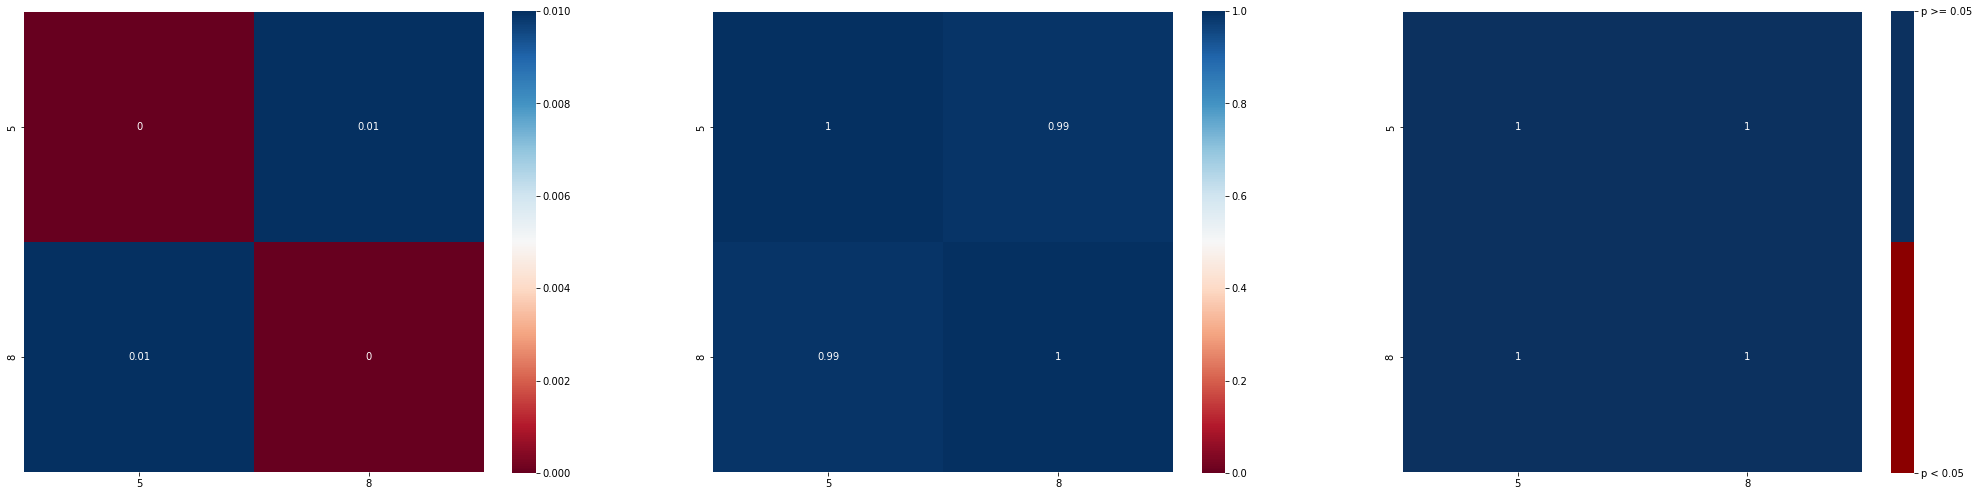

In [10]:
stat_table = get_stat_scores(stat_func, df_lsa)
dist_analysis(df_lsa.columns, stat_table)

In [ ]:
dist_analysis(df_lsa_bw, stat_func)

In [ ]:
# dist_analysis(df_xor, stat_func)